In [41]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Problem setup

we will find constant $a$ and $b$ from $u'  =  a*cos(bt) $ with initial condition $u(0) = 0 $    


Assume that we have observation data from 'exact solution'   $  u(t)  = \frac{1}{2\pi}   \sin(2\pi t)  $


We know that $a$ should be 1 and $b$ be $2\pi$, model will find these values. 


In [42]:
#DATA GENERATION

N = 100                                 #sample size

t_init = torch.zeros([1,1])             # initial data of size [1,1]
y_init = torch.zeros([1,1])

#domain = [0,M]
m = 1

#OBSERVATION DATA

def exactfct(x):
    return (1/(2*np.pi))*torch.sin(2*np.pi*x)

t_obs = m*torch.rand(N).view(-1,1)
y_obs = exactfct(t_obs)


#TRAIN DATA

t = torch.linspace(0,m,N).view(-1,1)    # data of size [N,1]  #view method reshape a tensor
t = t.requires_grad_(True)  
epoch = 7000

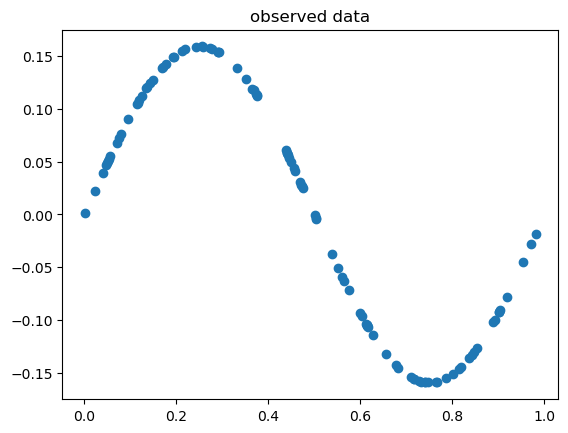

In [43]:
plt.plot(t_obs,y_obs,'o')
plt.title('observed data')
plt.show()

In [44]:
class NNforsimpleODEbackward(nn.Module) :
    def __init__(self, hidden_dims) :                    # Hidden_dims : [h1, h2, h3, ..., hn]
        super(NNforsimpleODEbackward, self).__init__()

        self.layers = []
        for i in range(len(hidden_dims)-1) :
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
        self.layers = nn.ModuleList(self.layers)           #similiar with  nn.seqential but argument can be list of layers

        for layer in self.layers :                       # Weight initialization ; give initial weight of model
            nn.init.xavier_uniform_(layer.weight)        # Also known as Glorot initialization

        self.act = nn.Tanh()                             # Nonlinear activation function

    def forward(self, x) :
        for layer in self.layers[:-1] :  # one before last layer
            x = self.act(layer(x))
        x = self.layers[-1](x)          #last layer
        return x


network = NNforsimpleODEbackward([1,64,64,1])
#LOSS FUNCTION

a = 2*torch.ones(1)
a = a.requires_grad_(True)
#a = torch.ones(1).requires_grad_(True)            # Parameter approximator
b = torch.ones(1).requires_grad_(True)               # Parameter approximator

optimizer = torch.optim.Adam([{'params': network.parameters()},{'params': a, 'lr':3e-3}, {'params': b, 'lr':1e-1}], lr=1e-3)

loss_f = nn.MSELoss()

In [45]:
# Train
loss_list = []
a_list, b_list = [], []

network.train()     # set model to train mode ( also evaluation mode exist.... model.eval())

for i in range(1, epoch+1) :
    optimizer.zero_grad()   # reset gradient that used in optimizer to zero after one iteration.  (model.zero_grad() resets all parameter in model)
    output = network(t)

    output_init = network(t_init)  # loss at initial value
    loss_init = loss_f(output_init, y_init)

    output_obs = network(t_obs)     # loss at obeservation points
    loss_obs = loss_f(output_obs, y_obs)

    output_x = torch.autograd.grad(output, t, grad_outputs=torch.ones_like(output), create_graph = True)[0] # get derivate u at x 
    
    loss_ODE = loss_f(output_x - a*torch.cos(b*t), torch.zeros_like(output_x))

    loss = loss_ODE + loss_init + loss_obs
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())
    a_list.append(a.item())  # item() change 1-d tensor to scalar
    b_list.append(b.item())
    

    if not i % 1000 :
        print('EPOCH : %6d/%6d | Loss_ode : %8.7f | Loss_init : %8.7f | Loss_obs : %8.7f' \
              %(i, epoch, loss_ODE.item(), loss_init.item(), loss_obs.item()))
        clear_output(wait=True)

   
 

EPOCH :   7000/  7000 | Loss_ode : 0.0001264 | Loss_init : 0.0000001 | Loss_obs : 0.0000062


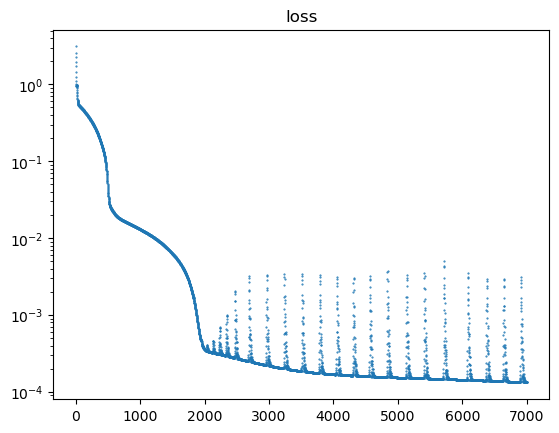

In [46]:
plt.plot(loss_list,'o',markersize = 0.5)
plt.yscale('log')
plt.title('loss')
plt.show()

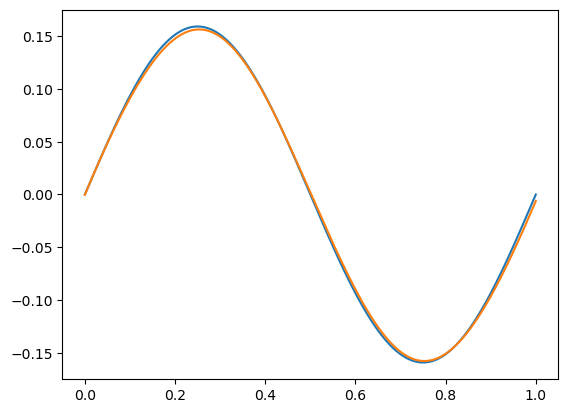

In [47]:
t = torch.linspace(0,m,400).view(-1,1)
network.eval()
prediction = network(t).detach()
plt.plot(t,exactfct(t))
plt.plot(t,prediction)
plt.show()

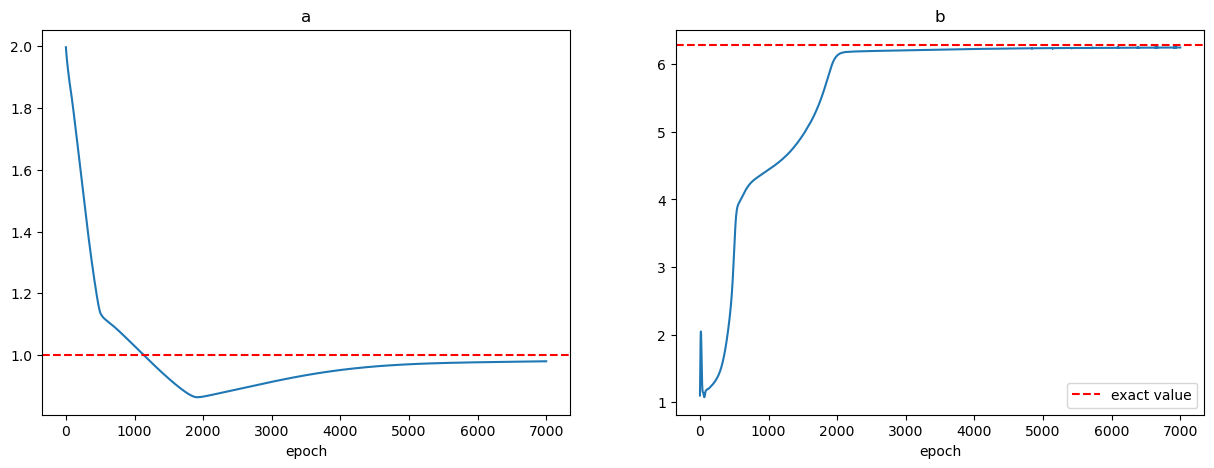

In [48]:
figure = plt.figure(figsize=(15,5))
ax1 = figure.add_subplot(1,2,1)
ax1.plot(a_list)
ax1.axhline(1,color = 'red' ,linestyle = '--', label = 'exact value' )
ax1.set_title('a')
ax1.set_xlabel('epoch')


ax2 = figure.add_subplot(1,2,2)
ax2.plot(b_list)
ax2.axhline(2*np.pi,color = 'red' ,linestyle = '--', label = 'exact value' )
ax2.set_title('b')
ax2.set_xlabel('epoch')

plt.legend()
plt.show()